<a href="https://www.kaggle.com/code/debbiechu/media-channel-performance-analyses?scriptVersionId=175351776" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Media Channel Performance Analyses

- Descriptive analysis by channel, by day, by week, and by month.
- Conduct predictive analyses to predict gross profit for the next day using time series model
- Find out which channel gives highest sales and profit by day

In [1]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression 
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import itertools
import missingno as msno

## EDA

In [2]:
df = pd.read_csv('Advertise.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.head()

/Users/debbie8265/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/07/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

  cache_array = _maybe_cache(arg, format, cache, convert_listlike)

/Users/debbie8265/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14/07/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

  cache_array = _maybe_cache(arg, format, cache, convert_listlike)

/Users/debbie8265/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '15/07/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

  cache_array = _maybe_cache(arg, format, cache, convert_listlike)

/Users/debbie8265/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWa

,Channel,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
Date,,,,,,
2021-05-07,Facebook,$720,"13,231",8,1,$50
2021-05-07,Google,"$1,328","22,413",208,35,"$1,750"
2021-05-07,LinkedIn,"$1,191","26,744",121,8,$500
2021-05-07,Reddit,$139,"3,136",30,4,$200
2021-06-07,Facebook,$742,"13,093",10,1,$50


### Data Types

In [3]:
df.dtypes

Channel               object
Ad Spend              object
Impressions           object
Clicks                 int64
Sales Transactions     int64
Gross Profit          object
dtype: object

In [4]:
df['Ad Spend'] = df['Ad Spend'].str.replace('$','')
df['Ad Spend'] = df['Ad Spend'].str.replace(',','')
df['Gross Profit'] = df['Gross Profit'].str.replace('$','')
df['Gross Profit'] = df['Gross Profit'].str.replace(',','')
df['Impressions'] = df['Impressions'].str.replace(',','')

/var/folders/d3/rk11lrks6hvd6knwh5lt542w0000gn/T/ipykernel_92334/3535267056.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

  df['Ad Spend'] = df['Ad Spend'].str.replace('$','')

/var/folders/d3/rk11lrks6hvd6knwh5lt542w0000gn/T/ipykernel_92334/3535267056.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

  df['Gross Profit'] = df['Gross Profit'].str.replace('$','')


In [5]:
df.head()

,Channel,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
Date,,,,,,
2021-05-07,Facebook,720,13231,8,1,50
2021-05-07,Google,1328,22413,208,35,1750
2021-05-07,LinkedIn,1191,26744,121,8,500
2021-05-07,Reddit,139,3136,30,4,200
2021-06-07,Facebook,742,13093,10,1,50


In [6]:
df.tail()

,Channel,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
Date,,,,,,
2021-10-23,Reddit,153,2742,38,5,300
2021-10-24,Facebook,735,13381,220,35,1800
2021-10-24,Google,1508,25193,463,56,3100
2021-10-24,LinkedIn,1378,35838,425,24,1200
2021-10-24,Reddit,149,2827,45,4,300


In [7]:
df['Ad Spend'] = df['Ad Spend'].astype('int')
df['Gross Profit'] = df['Gross Profit'].astype('int')
df['Impressions'] = df['Impressions'].astype('int')

In [8]:
df.dtypes

Channel               object
Ad Spend               int64
Impressions            int64
Clicks                 int64
Sales Transactions     int64
Gross Profit           int64
dtype: object

### Check Missing Values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 448 entries, 2021-05-07 to 2021-10-24

Data columns (total 6 columns):

 #   Column              Non-Null Count  Dtype 

---  ------              --------------  ----- 

 0   Channel             448 non-null    object

 1   Ad Spend            448 non-null    int64 

 2   Impressions         448 non-null    int64 

 3   Clicks              448 non-null    int64 

 4   Sales Transactions  448 non-null    int64 

 5   Gross Profit        448 non-null    int64 

dtypes: int64(5), object(1)

memory usage: 24.5+ KB


In [10]:
df.isna().sum()

Channel               0
Ad Spend              0
Impressions           0
Clicks                0
Sales Transactions    0
Gross Profit          0
dtype: int64

In [11]:
df.describe()

,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
count,448.000000,448.000000,448.000000,448.000000,448.000000
mean,872.265625,18428.986607,162.205357,18.341518,1048.660714
std,498.464401,11590.294024,124.301441,17.308282,962.111302
min,130.000000,2437.000000,8.000000,1.000000,50.000000
25%,505.500000,9773.750000,41.750000,5.000000,300.000000
50%,926.000000,18321.000000,144.000000,11.000000,600.000000
75%,1329.000000,27705.500000,253.000000,30.000000,1600.000000
max,1568.000000,41304.000000,525.000000,82.000000,4600.000000


### Histograms

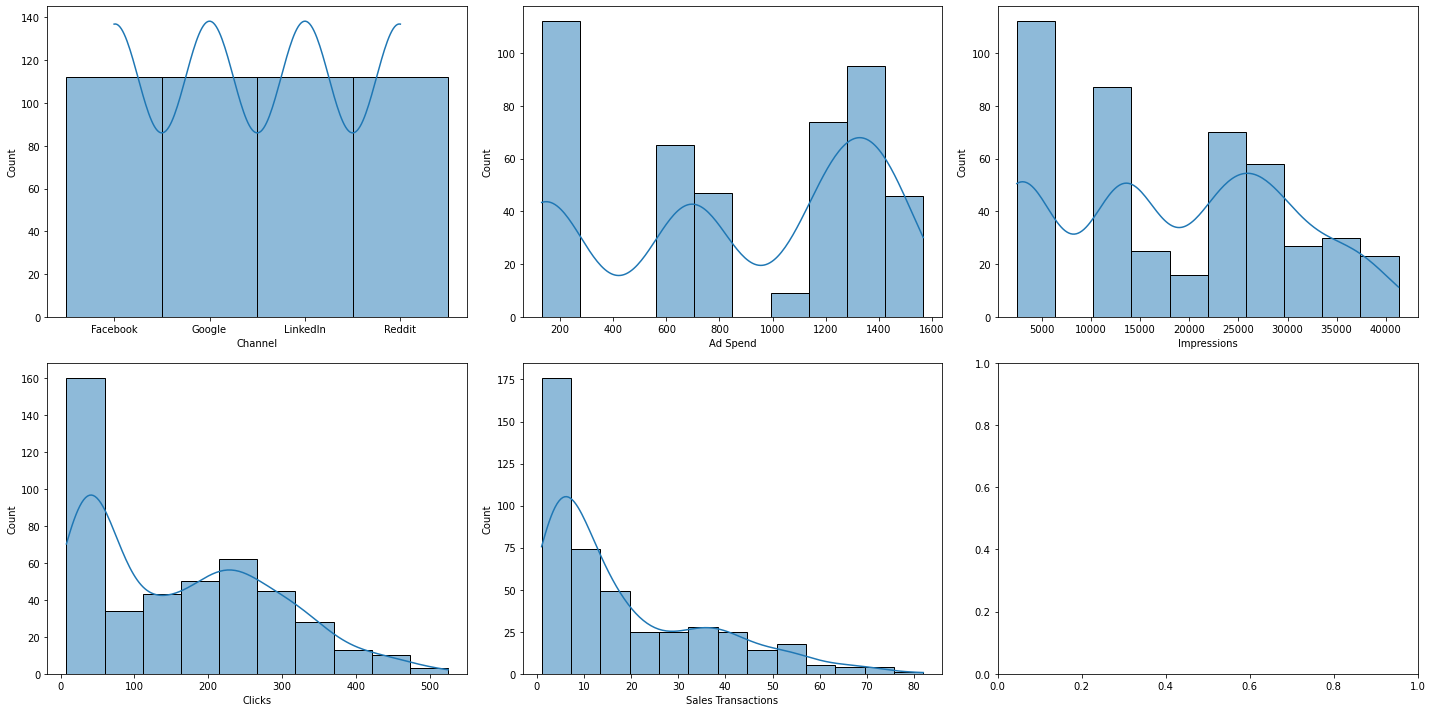

In [12]:
x_cols = df.columns

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()

for i in range(5):
    sns.histplot(data=df, x=x_cols[i], kde=True, ax=axs[i])
    
plt.tight_layout()
plt.show()

### Boxplot

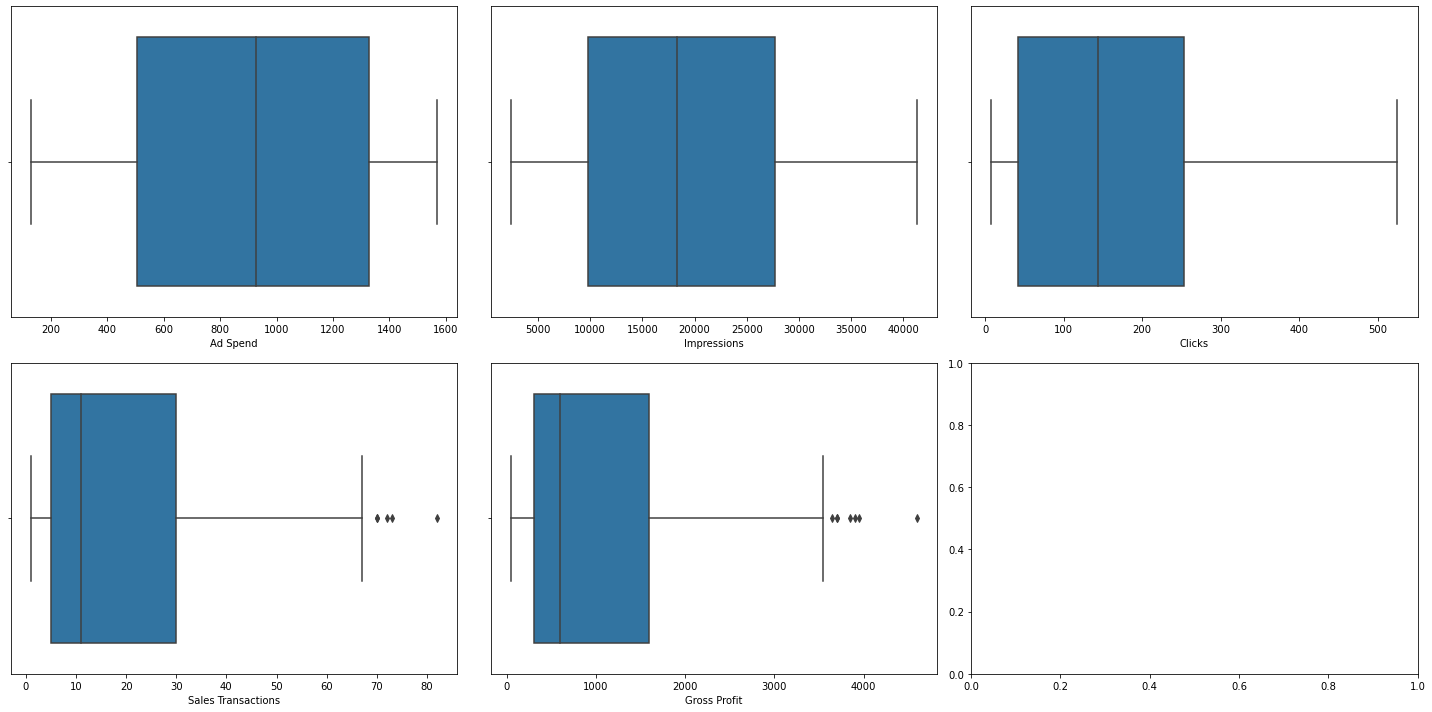

In [13]:
x_cols = list(df.drop(columns=['Channel']).columns)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()

for i in range(5):
    sns.boxplot(data=df, x=x_cols[i], ax=axs[i])
    
plt.tight_layout()
plt.show()

In [14]:
df['Channel'].value_counts()

Facebook    112
Google      112
LinkedIn    112
Reddit      112
Name: Channel, dtype: int64

<AxesSubplot:xlabel='Channel', ylabel='count'>

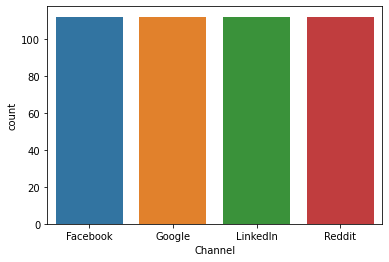

In [15]:
sns.countplot(x ='Channel', data = df)

## Descriptive analyses

### by channel

In [16]:
df_bychannel = df.groupby(['Channel']).mean()
df_bychannel

,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
Channel,,,,,
Facebook,695.660714,13481.616071,79.232143,11.687500,662.053571
Google,1337.553571,24472.133929,300.883929,44.339286,2503.125000
LinkedIn,1309.517857,32859.910714,232.946429,13.419643,748.214286
Reddit,146.330357,2902.285714,35.758929,3.919643,281.250000


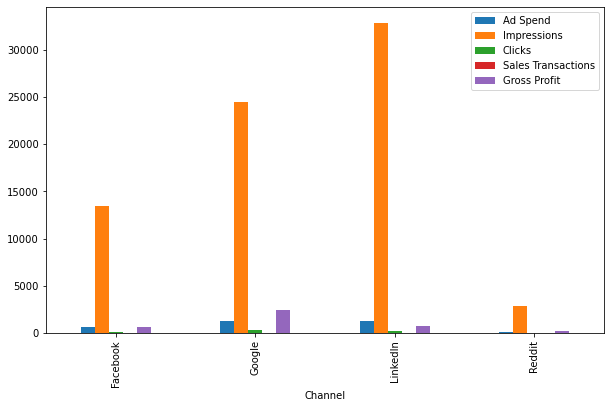

In [17]:
df_bychannel.plot.bar(figsize=(10,6))
plt.show()

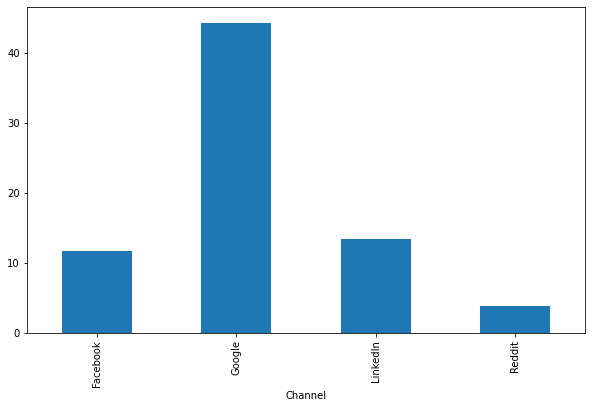

In [18]:
df_bychannel['Sales Transactions'].plot.bar(figsize=(10,6))
plt.show()

- LinkedIn has the highest impressions comparing to the rest of the channels.
- Google has the highest gross profit
- Google also has the highest clicks
- Google also has the highest sales transactions
- Impressions are way higher than the other variables, which makes sense because it's ad impressions their units are in thousands (pay per thousand views).

### Ad Spend

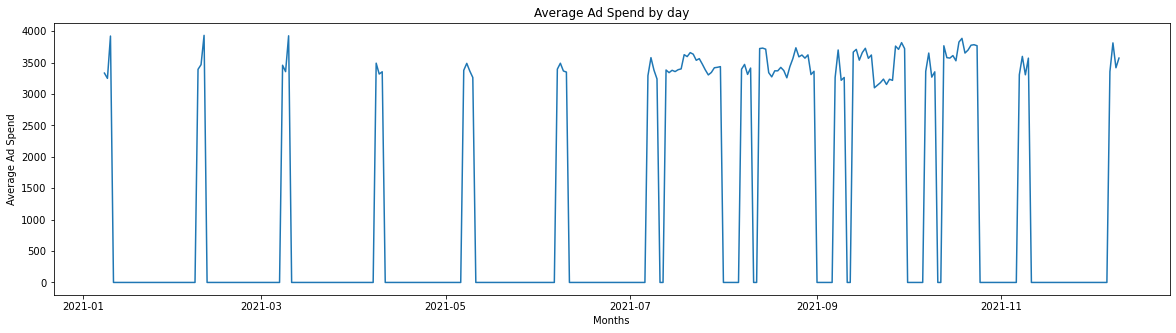

In [19]:
AS_daily_avg = df['Ad Spend'].resample('1D').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(AS_daily_avg.index, AS_daily_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Ad Spend')
ax.set_title('Average Ad Spend by day')
plt.show()

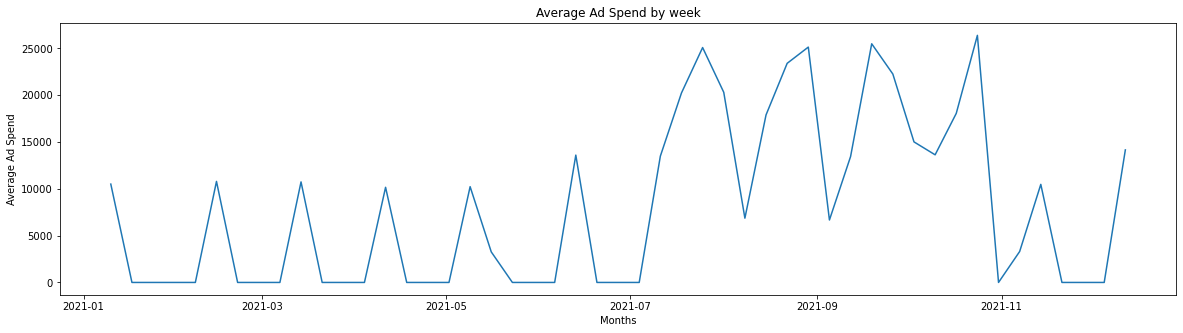

In [20]:
AS_weekly_avg = df['Ad Spend'].resample('1W').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(AS_weekly_avg.index, AS_weekly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Ad Spend')
ax.set_title('Average Ad Spend by week')
plt.show()

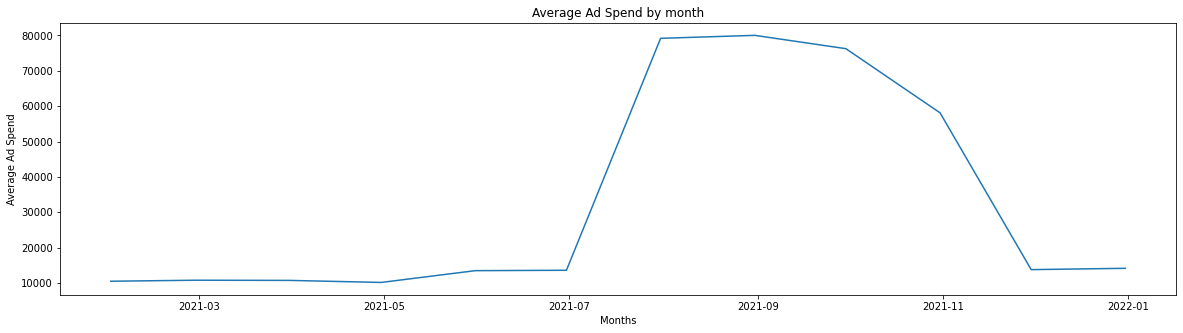

In [21]:
AS_monthly_avg = df['Ad Spend'].resample('1M').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(AS_monthly_avg.index, AS_monthly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Ad Spend')
ax.set_title('Average Ad Spend by month')
plt.show()

### Impressions

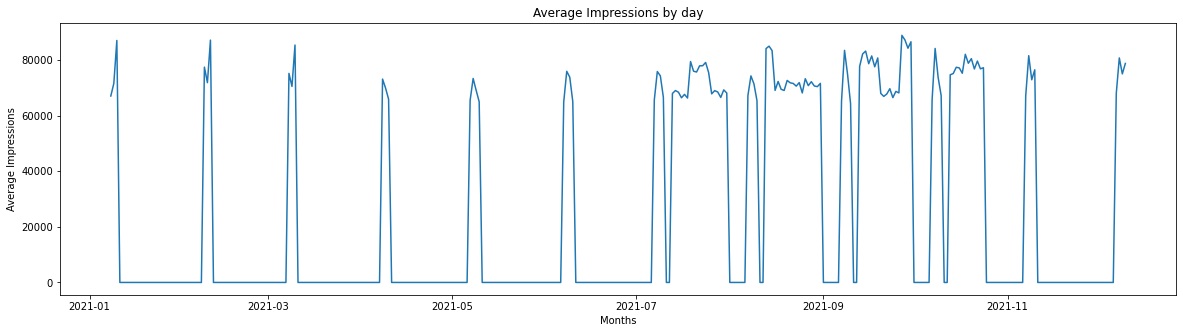

In [22]:
I_daily_avg = df['Impressions'].resample('1D').sum() 

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(I_daily_avg.index, I_daily_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Impressions')
ax.set_title('Average Impressions by day')
plt.show()

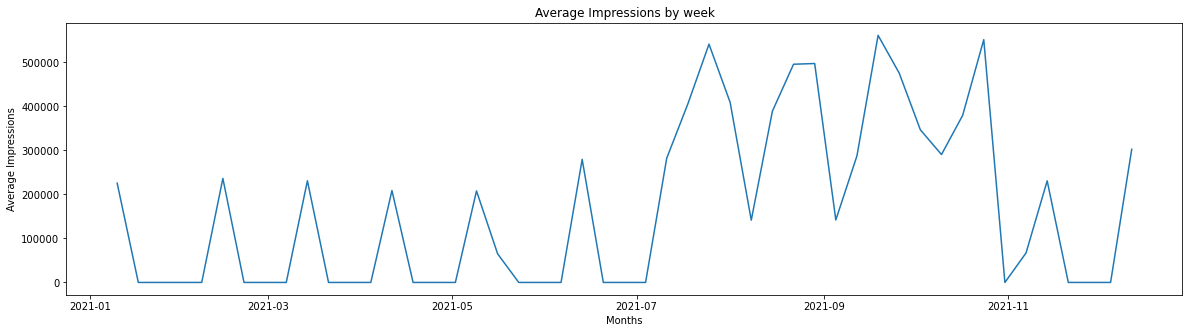

In [23]:
I_weekly_avg = df['Impressions'].resample('1W').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(I_weekly_avg.index, I_weekly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Impressions')
ax.set_title('Average Impressions by week')
plt.show()

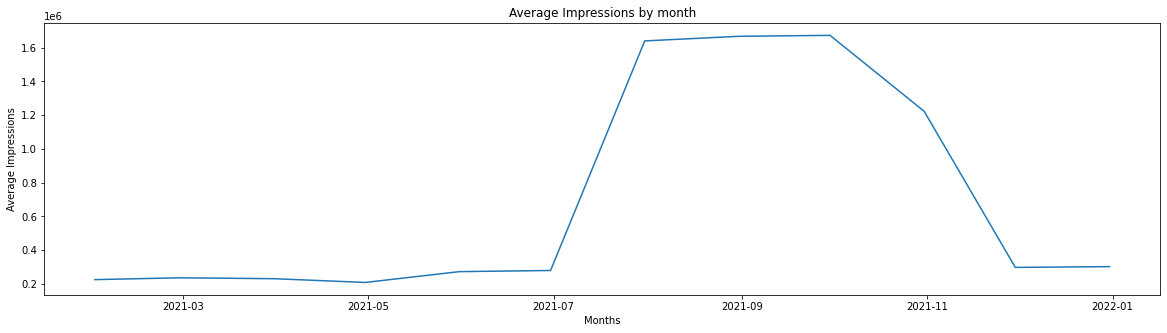

In [24]:
I_monthly_avg = df['Impressions'].resample('1M').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(I_monthly_avg.index, I_monthly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Impressions')
ax.set_title('Average Impressions by month')
plt.show()

### Clicks

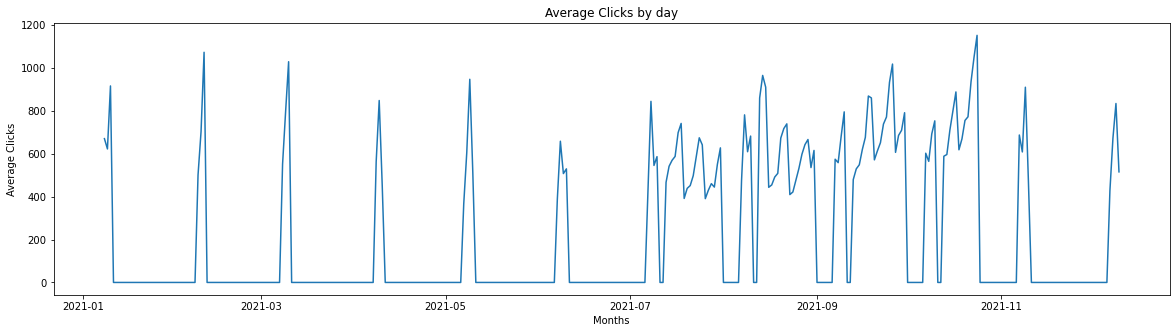

In [25]:
C_daily_avg = df['Clicks'].resample('1D').sum() 

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(C_daily_avg.index, C_daily_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Clicks')
ax.set_title('Average Clicks by day')
plt.show()

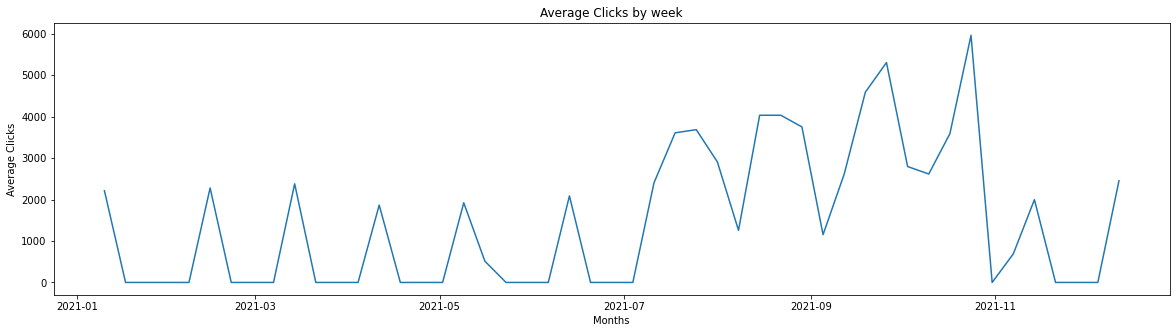

In [26]:
C_weekly_avg = df['Clicks'].resample('1W').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(C_weekly_avg.index, C_weekly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Clicks')
ax.set_title('Average Clicks by week')
plt.show()

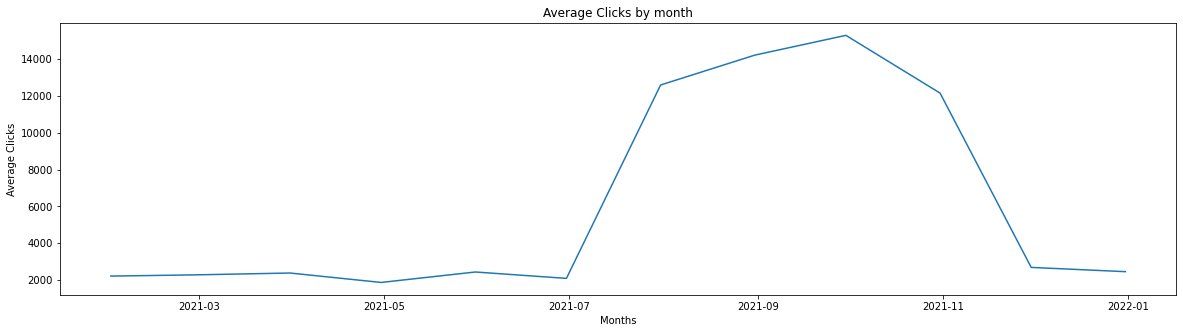

In [27]:
C_monthly_avg = df['Clicks'].resample('1M').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(C_monthly_avg.index, C_monthly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Clicks')
ax.set_title('Average Clicks by month')
plt.show()

### Sales Transactions

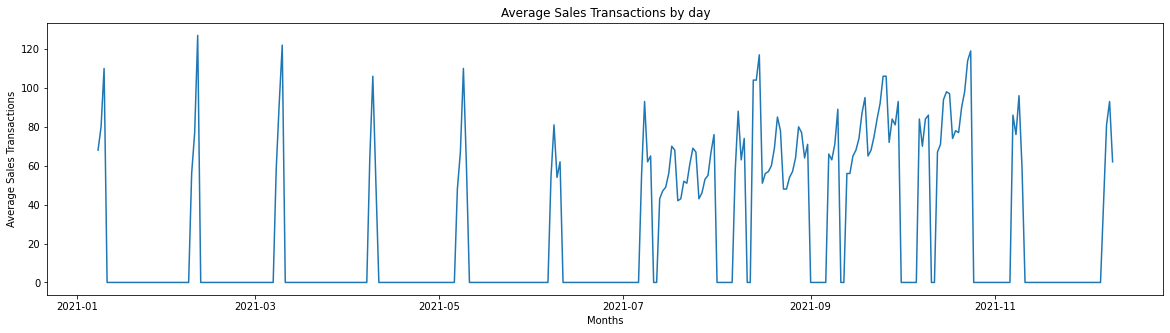

In [28]:
ST_daily_avg = df['Sales Transactions'].resample('1D').sum() 

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(ST_daily_avg.index, ST_daily_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Sales Transactions')
ax.set_title('Average Sales Transactions by day')
plt.show()

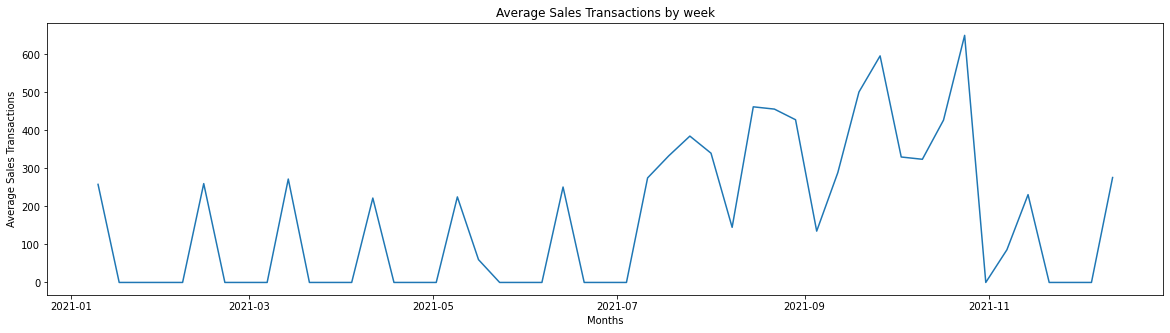

In [29]:
ST_weekly_avg = df['Sales Transactions'].resample('1W').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(ST_weekly_avg.index, ST_weekly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Sales Transactions')
ax.set_title('Average Sales Transactions by week')
plt.show()

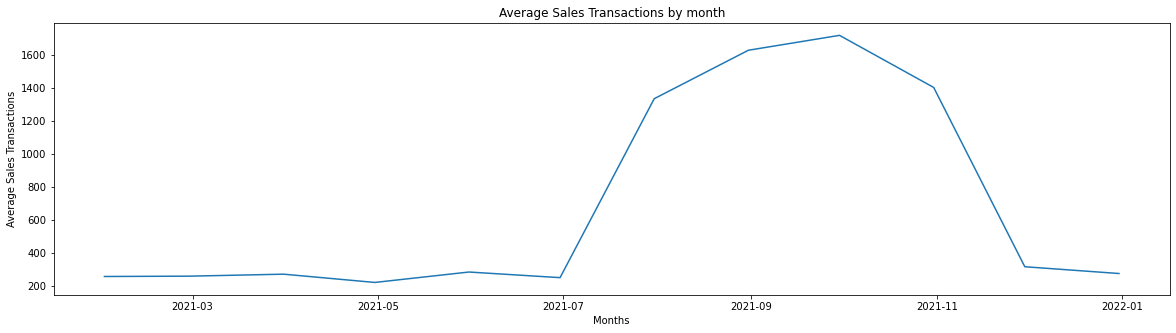

In [30]:
ST_monthly_avg = df['Sales Transactions'].resample('1M').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(ST_monthly_avg.index, ST_monthly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Sales Transactions')
ax.set_title('Average Sales Transactions by month')
plt.show()

### Gross Profit

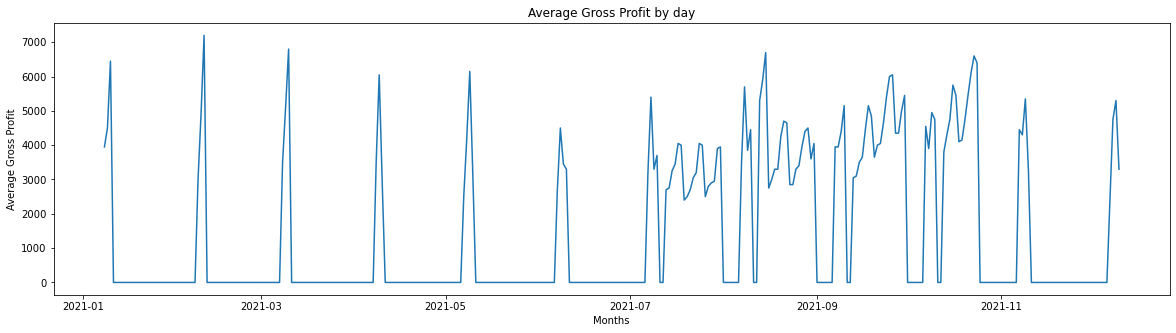

In [31]:
GP_daily_avg = df['Gross Profit'].resample('1D').sum() 

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(GP_daily_avg.index, GP_daily_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Gross Profit')
ax.set_title('Average Gross Profit by day')
plt.show()

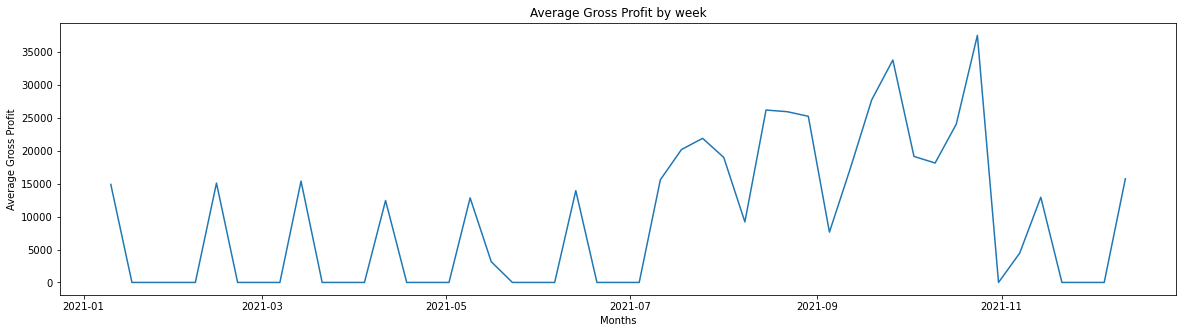

In [32]:
GP_weekly_avg = df['Gross Profit'].resample('1W').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(GP_weekly_avg.index, GP_weekly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Gross Profit')
ax.set_title('Average Gross Profit by week')
plt.show()

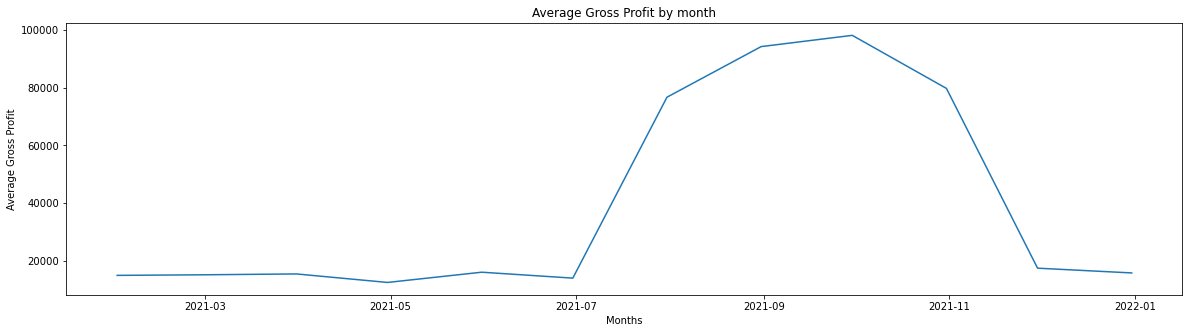

In [33]:
GP_monthly_avg = df['Gross Profit'].resample('1M').sum()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(GP_monthly_avg.index, GP_monthly_avg.values, label='Average')
ax.set_xlabel('Months')
ax.set_ylabel('Average Gross Profit')
ax.set_title('Average Gross Profit by month')
plt.show()

- All of the variables, ad spend, impression, clicks, sales transaction, and gross profit all follow the same trend. The highest month is in November, most probably because of the pre-sales season (black friday, Thanksgiving, Cyber monday and Xmas). Then around March is the next highest month with ad spend, probably because of the spring sale.

### Correlation between variables

In [34]:
#check distribution
columns = ['Ad Spend', 'Impressions', 'Clicks', 'Sales Transactions','Gross Profit']
for column in columns:
    if shapiro(df[column])[1] > 0.05:
        print(column, 'is normally distributed')
    else:
        print(column, 'is not normally distributed')

Ad Spend is not normally distributed

Impressions is not normally distributed

Clicks is not normally distributed

Sales Transactions is not normally distributed

Gross Profit is not normally distributed


<AxesSubplot:>

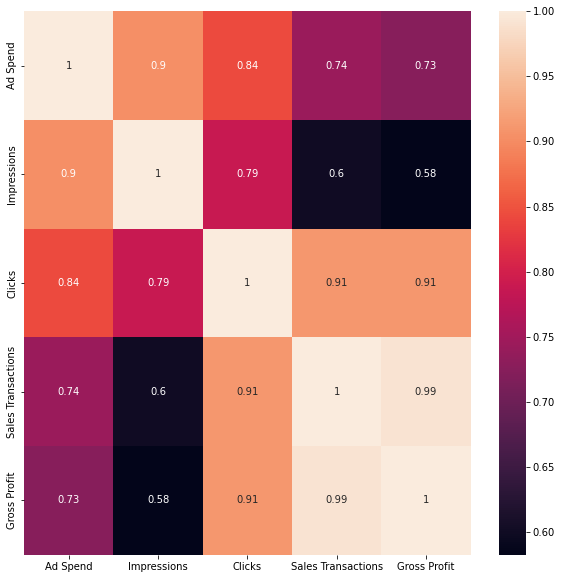

In [35]:
plt.figure(figsize=(10,10))
cor = df.corr(method='spearman')
sns.heatmap(cor, annot=True)

- All of the variables are highly positively correlated (correlation coefficient > 0.7), except for Impressions vs Sales Transaction, and IMpressions vs Gross Profit, which are moderatly positively correlated.

## Predictive analyses

### Daily Dataset

In [36]:
daily_df = pd.concat([AS_daily_avg, I_daily_avg, C_daily_avg, ST_daily_avg, GP_daily_avg], axis=1)
daily_df.head()

,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
Date,,,,,
2021-01-08,3334,67063,671,68,3950
2021-01-09,3250,71577,623,80,4500
2021-01-10,3924,87049,917,110,6450
2021-01-11,0,0,0,0,0
2021-01-12,0,0,0,0,0


In [37]:
daily_df.tail()

,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
Date,,,,,
2021-12-06,0,0,0,0,0
2021-12-07,3356,68065,428,40,2400
2021-12-08,3815,80771,673,81,4750
2021-12-09,3419,75021,835,93,5300
2021-12-10,3573,78775,516,62,3300


In [38]:
X=daily_df.drop(columns=['Gross Profit'])
y=daily_df['Gross Profit']

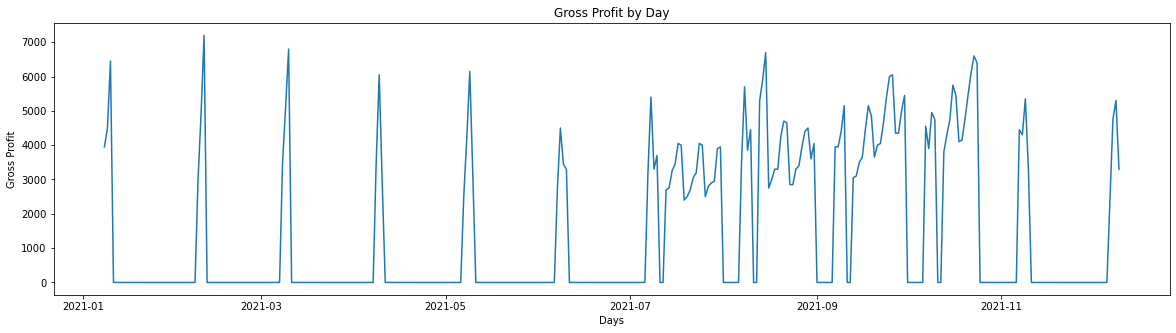

In [39]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(y.index, y.values, label='Gross Profit')
ax.set_xlabel('Days')
ax.set_ylabel('Gross Profit')
ax.set_title('Gross Profit by Day')
plt.show()

### Timeseries forecasting method: use all the forecast the last value in GP

In [50]:
# check stationarity

from statsmodels.tsa.stattools import adfuller

result = adfuller(y[:-1])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.581374

p-value: 0.000140

Critical Values:

	1%: -3.450

	5%: -2.870

	10%: -2.571


Data (Gross Profit) is stationary

In [42]:
# check seasonality

# from the line plot it seems that there is a seasonality

In [51]:
# model
import pmdarima as pm
model = pm.auto_arima(y[:-1], seasonal=True, m=30, suppress_warnings=True)

# Forecast the next value

n_periods = 1  # Number of periods to forecast forward
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

print(f"Forecasted value: {forecast[0]}")
print(f"95% Confidence Interval: {conf_int[0]}")

Forecasted value: 3479.1679225623443

95% Confidence Interval: [ 995.62310749 5962.71273764]


In [52]:
# last value in GP
y[-1]

3300

Pretty close! We will use all the y values to predict the next y value.

In [53]:
# model

model = pm.auto_arima(y, seasonal=True, m=30, suppress_warnings=True)

# Forecast the next value

n_periods = 1  # Number of periods to forecast forward
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

print(f"Forecasted value: {forecast[0]}")
print(f"95% Confidence Interval: {conf_int[0]}")

Forecasted value: 1470.2580633153962

95% Confidence Interval: [-1009.63839875  3950.15452538]


The next day Gross Profit value is forecasted to be **1470**.

### Multi-regression method: no forecasting capability, but can see which marketing method contributes to profit based on coefficients.

In [46]:
#80/20
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100, shuffle=True)

#train set performance
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            


Dep. Variable:           Gross Profit   R-squared:                       0.996

Model:                            OLS   Adj. R-squared:                  0.996

Method:                 Least Squares   F-statistic:                 1.708e+04

Date:                Wed, 12 Apr 2023   Prob (F-statistic):          2.40e-317

Time:                        00:21:34   Log-Likelihood:                -1691.8

No. Observations:                 269   AIC:                             3394.

Df Residuals:                     264   BIC:                             3411.

Df Model:                           4                                         

Covariance Type:            nonrobust                                         


                         coef    std err          t      P>|t|      [0.025      0.975]

--------------------------------------------------------------------------------------

const                 

### Check Multicollinearity

In [161]:
X=daily_df.drop(columns=['Gross Profit'])
y=daily_df['Gross Profit']

X_constant = sm.add_constant(X)
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]

vif_df=pd.DataFrame({'vif': vif[1:]}, index=X.columns).T
vif_df

,Ad Spend,Impressions,Clicks,Sales Transactions
vif,251.659079,265.810968,115.19817,112.824751


In [165]:
#take out Impressions & Ad Spend
X=daily_df.drop(columns=['Gross Profit','Impressions','Ad Spend'])
y=daily_df['Gross Profit']

X_constant = sm.add_constant(X)
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]

vif_df=pd.DataFrame({'vif': vif[1:]}, index=X.columns).T
vif_df

,Clicks,Sales Transactions
vif,110.125327,110.125327


In [171]:
X=daily_df.drop(columns=['Gross Profit','Impressions','Ad Spend'])
y=daily_df['Gross Profit']

#80/20
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100, shuffle=True)

#train set performance
x_train = sm.add_constant(x_train)

model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            


Dep. Variable:           Gross Profit   R-squared:                       0.996

Model:                            OLS   Adj. R-squared:                  0.996

Method:                 Least Squares   F-statistic:                 3.420e+04

Date:                Tue, 27 Feb 2024   Prob (F-statistic):          1.69e-321

Time:                        14:42:03   Log-Likelihood:                -1692.7

No. Observations:                 269   AIC:                             3391.

Df Residuals:                     266   BIC:                             3402.

Df Model:                           2                                         

Covariance Type:            nonrobust                                         


                         coef    std err          t      P>|t|      [0.025      0.975]

--------------------------------------------------------------------------------------

const                 

In [172]:
x_test = sm.add_constant(x_test)
y_pred = model.predict(x_test) # Predict using the best alpha

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the scores
print("R-squared:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

R-squared: 0.9972270190493194

MAE: 52.29332298499546

RMSE: 104.65344586601869


Both **Clicks** and **Sales Transactions** contributes to the increase of Gross Profit, with **Sales Transaction** having more impact.

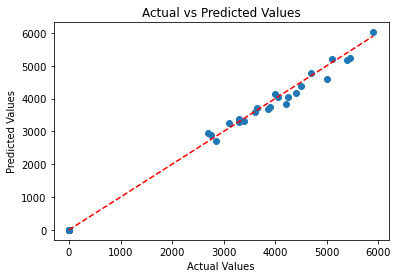

In [173]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## Which channel yeilds highest sales and profit

### By day

'Date' will be an additional factor, so we can use **Two-Way Repeated Measures ANOVA** and **mixed-effects model**.

In [101]:
df.head()

,Channel,Ad Spend,Impressions,Clicks,Sales Transactions,Gross Profit
Date,,,,,,
2021-05-07,Facebook,720,13231,8,1,50
2021-05-07,Google,1328,22413,208,35,1750
2021-05-07,LinkedIn,1191,26744,121,8,500
2021-05-07,Reddit,139,3136,30,4,200
2021-06-07,Facebook,742,13093,10,1,50


### Sales

In [104]:
# keep only Sales Transactions for df_sales
df_sales = df.drop(['Ad Spend','Impressions','Clicks','Gross Profit'], axis=1)
df_sales.head(20)

,Channel,Sales Transactions
Date,,
2021-05-07,Facebook,1
2021-05-07,Google,35
2021-05-07,LinkedIn,8
2021-05-07,Reddit,4
2021-06-07,Facebook,1
2021-06-07,Google,40
2021-06-07,LinkedIn,9
2021-06-07,Reddit,4
2021-07-07,Facebook,1


In [120]:
df_reset = df_sales.reset_index()
df_reset['Date'] = pd.to_datetime(df_reset['Date'])
df_reset.head()

,Date,Channel,Sales Transactions
0,2021-05-07,Facebook,1
1,2021-05-07,Google,35
2,2021-05-07,LinkedIn,8
3,2021-05-07,Reddit,4
4,2021-06-07,Facebook,1


In [129]:
# rename Sales Transactions to Sales
df_reset = df_reset.rename(columns={'Sales Transactions': 'Sales'})

### Two-Way Repeated Measures ANOVA

Perform a Two-Way Repeated Measures ANOVA to test if there is an overall statistically significant difference in sales across different channels while considering the effect of time

In [130]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(df_reset, 'Sales', 'Date', within=['Channel'])
res = aovrm.fit()

# Print the ANOVA table
print(res.summary())

                 Anova


        F Value  Num DF  Den DF  Pr > F

---------------------------------------

Channel 724.0118 3.0000 333.0000 0.0000





There is a statistically significant difference (p<0.05)

### Mixed effects model

Create a mixed-effect model with "Date" as the random effect. By removing the residuals (noise) of the mixed model, it makes the effects of fixed and random variables clearer. 

In [132]:
# Fit a mixed effects model
from statsmodels.formula.api import mixedlm
md = mixedlm("Sales ~ Channel", df_reset, groups=df_reset["Date"]) # Date is a random effect
mdf = md.fit()

print(mdf.summary())

            Mixed Linear Model Regression Results


Model:              MixedLM   Dependent Variable:   Sales     

No. Observations:   448       Method:               REML      

No. Groups:         112       Scale:                49.1091   

Min. group size:    4         Log-Likelihood:       -1542.3375

Max. group size:    4         Converged:            Yes       

Mean group size:    4.0                                       

--------------------------------------------------------------

                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]

--------------------------------------------------------------

Intercept           11.687    0.740 15.790 0.000 10.237 13.138

Channel[T.Google]   32.652    0.936 34.867 0.000 30.816 34.487

Channel[T.LinkedIn]  1.732    0.936  1.850 0.064 -0.103  3.568

Channel[T.Reddit]   -7.768    0.936 -8.295 0.000 -9.603 -5.932

Group Var           12.253    0.543                           





In [133]:
# when we perform pairwise analysis without noise, 
# we can attribute the difference in channel performances directly to channels (fixed) and time (random)
tukey = pairwise_tukeyhsd(endog=df_reset['Sales'] - mdf.resid, groups=df_reset['Channel'], alpha=0.05)

print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   


 group1   group2  meandiff p-adj  lower    upper   reject

---------------------------------------------------------

Facebook   Google  32.6518   0.0  31.7993  33.5043   True

Facebook LinkedIn   1.7321   0.0   0.8796   2.5847   True

Facebook   Reddit  -7.7679   0.0  -8.6204  -6.9153   True

  Google LinkedIn -30.9196   0.0 -31.7722 -30.0671   True

  Google   Reddit -40.4196   0.0 -41.2722 -39.5671   True

LinkedIn   Reddit     -9.5   0.0 -10.3525  -8.6475   True

---------------------------------------------------------


Sales performance by day: **Reddit** > **Facebook** > **LinkedIn** > **Google**

### Gross Profit

In [138]:
# keep only Sales Transactions for df_sales
df_profit = df.drop(['Ad Spend','Impressions','Clicks','Sales Transactions'], axis=1)
df_profit.head(20)

,Channel,Gross Profit
Date,,
2021-05-07,Facebook,50
2021-05-07,Google,1750
2021-05-07,LinkedIn,500
2021-05-07,Reddit,200
2021-06-07,Facebook,50
2021-06-07,Google,1950
2021-06-07,LinkedIn,450
2021-06-07,Reddit,250
2021-07-07,Facebook,50


In [139]:
df_reset = df_profit.reset_index()
df_reset['Date'] = pd.to_datetime(df_reset['Date'])
df_reset.head()

,Date,Channel,Gross Profit
0,2021-05-07,Facebook,50
1,2021-05-07,Google,1750
2,2021-05-07,LinkedIn,500
3,2021-05-07,Reddit,200
4,2021-06-07,Facebook,50


In [140]:
# rename Sales Transactions to Sales
df_reset = df_reset.rename(columns={'Gross Profit': 'Profit'})

### Two-Way Repeated Measures ANOVA

Perform a Two-Way Repeated Measures ANOVA to test if there is an overall statistically significant difference in profit across different channels while considering the effect of time

In [141]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(df_reset, 'Profit', 'Date', within=['Channel'])
res = aovrm.fit()

# Print the ANOVA table
print(res.summary())

                 Anova


        F Value  Num DF  Den DF  Pr > F

---------------------------------------

Channel 747.8432 3.0000 333.0000 0.0000





There is a statistically significant difference (p<0.05)

### Mixed effects model

Create a mixed-effect model with "Date" as the random effect. By removing the residuals (noise) of the mixed model, it makes the effects of fixed and random variables clearer. 

In [142]:
# Fit a mixed effects model
from statsmodels.formula.api import mixedlm
md = mixedlm("Profit ~ Channel", df_reset, groups=df_reset["Date"]) # Date is a random effect
mdf = md.fit()

print(mdf.summary())

                Mixed Linear Model Regression Results


Model:                MixedLM     Dependent Variable:     Profit     

No. Observations:     448         Method:                 REML       

No. Groups:           112         Scale:                  146974.7923

Min. group size:      4           Log-Likelihood:         -3323.3040 

Max. group size:      4           Converged:              Yes        

Mean group size:      4.0                                            

---------------------------------------------------------------------

                      Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 

---------------------------------------------------------------------

Intercept             662.054   41.107 16.106 0.000  581.486  742.621

Channel[T.Google]    1841.071   51.230 35.937 0.000 1740.662 1941.481

Channel[T.LinkedIn]    86.161   51.230  1.682 0.093  -14.249  186.570

Channel[T.Reddit]    -380.804   51.230 -7.433 0.000 -481.213 -280.394

Group Var           4

In [143]:
# when we perform pairwise analysis without noise, 
# we can attribute the difference in channel performances directly to channels (fixed) and time (random)
tukey = pairwise_tukeyhsd(endog=df_reset['Profit'] - mdf.resid, groups=df_reset['Channel'], alpha=0.05)

print(tukey.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       


 group1   group2   meandiff  p-adj    lower      upper    reject

----------------------------------------------------------------

Facebook   Google  1841.0714    0.0  1789.2444  1892.8984   True

Facebook LinkedIn    86.1607 0.0001    34.3337   137.9877   True

Facebook   Reddit  -380.8036    0.0  -432.6306  -328.9766   True

  Google LinkedIn -1754.9107    0.0 -1806.7377 -1703.0837   True

  Google   Reddit  -2221.875    0.0  -2273.702  -2170.048   True

LinkedIn   Reddit  -466.9643    0.0  -518.7913  -415.1373   True

----------------------------------------------------------------


Profit performance by day: **Reddit** > **Facebook** > **LinkedIn** > **Google**

## Conclusion



- Based on multilinear regression models, both Clicks and Sales Transactions contributes to the increase of Gross Profit, with Sales Transaction having more impact. Therefore, we should improve ad quality to increase clicks, which would lead to higher sales and profit.  
- Based on our ANOVA and pairwise tests, it's evident that Reddit exhibits the highest sales and profit performance, followed by Facebook, LinkedIn, and finally, Google. Therefore, investment amounts should also align with this sequence.